# 1. Import Necessary Packages

In [ ]:
!pip install librosa torchaudio soundfile kagglehub torchcodec pystoi pesq

In [ ]:
# Main packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import glob

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F_functional
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Audio
import librosa
import librosa.display
import IPython.display as ipd
import torchaudio
import soundfile as sf
from pesq import pesq
from pystoi.stoi import stoi

# Kaggle
import kagglehub

# Warning
import warnings
warnings.filterwarnings("ignore")

# 2. Load DataSet

## 2.1 Noise Dataset

In [ ]:
path_noise_datasets = kagglehub.dataset_download("minsithu/audio-noise-dataset")

print("Path to dataset files:", path_noise_datasets)

Using Colab cache for faster access to the 'audio-noise-dataset' dataset.
Path to dataset files: /kaggle/input/audio-noise-dataset


In [ ]:
noise_datasets_1 = os.path.join(path_noise_datasets)
noise_datasets_1_path = os.listdir(noise_datasets_1)
noise_datasets_1_path

['sample-8.webm',
 'sample-1.webm',
 'sample-2.webm',
 'sample-7.webm',
 'sample-6.webm',
 'sample-5.webm',
 'sample-3.webm',
 'sample-10.webm',
 'sample-9.webm',
 'sample-4.webm']

In [ ]:
durations = []
for filename in noise_datasets_1_path:
    file_path = os.path.join(noise_datasets_1, filename)
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except Exception as e:
        print(f"Could not process {filename}: {e}")

if durations:
    max_duration = np.max(durations)
    min_duration = np.min(durations)
    median_duration = np.median(durations)
    average_duration = np.mean(durations)

    print(f"\nAudio Duration Statistics:")
    print(f"Maximum Duration: {max_duration:.2f} seconds")
    print(f"Minimum Duration: {min_duration:.2f} seconds")
    print(f"Median Duration: {median_duration:.2f} seconds")
    print(f"Average Duration: {average_duration:.2f} seconds")
else:
    print("No durations could be calculated.")


Audio Duration Statistics:
Maximum Duration: 21.72 seconds
Minimum Duration: 5.40 seconds
Median Duration: 10.80 seconds
Average Duration: 9.96 seconds


## 2.2 Background Noise Dataset

In [ ]:
path_bg_noise_datasets = kagglehub.dataset_download("moazabdeljalil/back-ground-noise")

print("Path to dataset files:", path_bg_noise_datasets)

Using Colab cache for faster access to the 'back-ground-noise' dataset.
Path to dataset files: /kaggle/input/back-ground-noise


In [ ]:
noise_datasets_2 = os.path.join(path_bg_noise_datasets, 'bk')
noise_datasets_2_path = os.listdir(noise_datasets_2)
print(f'number of data sets = {len(noise_datasets_2_path)}')
noise_datasets_2_path[:10]

number of data sets = 1346


['chunk_987.wav',
 'chunk_945.wav',
 'chunk_558.wav',
 'chunk_1196.wav',
 'chunk_780.wav',
 'chunk_015.wav',
 'chunk_900.wav',
 'chunk_663.wav',
 'chunk_655.wav',
 'chunk_847.wav']

In [ ]:
durations = []
for filename in noise_datasets_2_path:
    file_path = os.path.join(noise_datasets_2, filename)
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except Exception as e:
        print(f"Could not process {filename}: {e}")

if durations:
    max_duration = np.max(durations)
    min_duration = np.min(durations)
    median_duration = np.median(durations)
    average_duration = np.mean(durations)

    print(f"\nAudio Duration Statistics:")
    print(f"Maximum Duration: {max_duration:.2f} seconds")
    print(f"Minimum Duration: {min_duration:.2f} seconds")
    print(f"Median Duration: {median_duration:.2f} seconds")
    print(f"Average Duration: {average_duration:.2f} seconds")
else:
    print("No durations could be calculated.")


Audio Duration Statistics:
Maximum Duration: 3.00 seconds
Minimum Duration: 3.00 seconds
Median Duration: 3.00 seconds
Average Duration: 3.00 seconds


## 2.3 Noise + NoNoise Datasets

In [ ]:
path_noise_clean_datasets = kagglehub.dataset_download("lazyrac00n/speech-activity-detection-datasets")

print("Path to dataset files:", path_noise_clean_datasets)

Using Colab cache for faster access to the 'speech-activity-detection-datasets' dataset.
Path to dataset files: /kaggle/input/speech-activity-detection-datasets


### 2.3.1 Noise Datasets

In [ ]:
BABBLE = os.path.join(path_noise_clean_datasets, '/Data/Audio/Noizeus/Babble')
CAR = os.path.join(path_noise_clean_datasets, '/Data/Audio/Noizeus/Car')
RESTAURANT = os.path.join(path_noise_clean_datasets, '/Data/Audio/Noizeus/Restaurant')
STATION = os.path.join(path_noise_clean_datasets, '/Data/Audio/Noizeus/Station')
STREET = os.path.join(path_noise_clean_datasets, '/Data/Audio/Noizeus/Street')
TRAIN = os.path.join(path_noise_clean_datasets, '/Data/Audio/Noizeus/Train')

In [ ]:
noise_3_datasets_dir = 'noise_3_datasets'
if not os.path.exists(noise_3_datasets_dir):
    os.makedirs(noise_3_datasets_dir, exist_ok=True)
    print(f"Directory '{noise_3_datasets_dir}' created.")
else:
    print(f"Directory '{noise_3_datasets_dir}' already exists.")

Directory 'noise_3_datasets' already exists.


In [ ]:
source_noise_dirs = [BABBLE, CAR, RESTAURANT, STATION, STREET, TRAIN]
print(f"Source noise directories collected: {source_noise_dirs}")

Source noise directories collected: ['/Data/Audio/Noizeus/Babble', '/Data/Audio/Noizeus/Car', '/Data/Audio/Noizeus/Restaurant', '/Data/Audio/Noizeus/Station', '/Data/Audio/Noizeus/Street', '/Data/Audio/Noizeus/Train']


In [ ]:
import shutil

copied_files_count = 0

for source_dir in source_noise_dirs:
    if not os.path.isdir(source_dir):
        print(f"Warning: Source directory '{source_dir}' not found or not a directory. Skipping.")
        continue

    for filename in os.listdir(source_dir):
        source_file_path = os.path.join(source_dir, filename)
        destination_file_path = os.path.join(noise_3_datasets_dir, filename)
        try:
            shutil.copy(source_file_path, destination_file_path)
            copied_files_count += 1
        except Exception as e:
            print(f"Error copying {source_file_path} to {destination_file_path}: {e}")

print(f"Total files copied to '{noise_3_datasets_dir}': {copied_files_count}")

Total files copied to 'noise_3_datasets': 0


In [ ]:
BABBLE = os.path.join(path_noise_clean_datasets, 'Data/Audio/Noizeus/Babble')
CAR = os.path.join(path_noise_clean_datasets, 'Data/Audio/Noizeus/Car')
RESTAURANT = os.path.join(path_noise_clean_datasets, 'Data/Audio/Noizeus/Restaurant')
STATION = os.path.join(path_noise_clean_datasets, 'Data/Audio/Noizeus/Station')
STREET = os.path.join(path_noise_clean_datasets, 'Data/Audio/Noizeus/Street')
TRAIN = os.path.join(path_noise_clean_datasets, 'Data/Audio/Noizeus/Train')

source_noise_dirs = [BABBLE, CAR, RESTAURANT, STATION, STREET, TRAIN]
print(f"Corrected source noise directories: {source_noise_dirs}")

Corrected source noise directories: ['/kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/Babble', '/kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/Car', '/kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/Restaurant', '/kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/Station', '/kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/Street', '/kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/Train']


In [ ]:
import shutil

copied_files_count = 0

for source_dir in source_noise_dirs:
    if not os.path.isdir(source_dir):
        print(f"Warning: Source directory '{source_dir}' not found or not a directory. Skipping.")
        continue

    for filename in os.listdir(source_dir):
        source_file_path = os.path.join(source_dir, filename)
        destination_file_path = os.path.join(noise_3_datasets_dir, filename)
        try:
            shutil.copy(source_file_path, destination_file_path)
            copied_files_count += 1
        except Exception as e:
            print(f"Error copying {source_file_path} to {destination_file_path}: {e}")

print(f"Total files copied to '{noise_3_datasets_dir}': {copied_files_count}")

Total files copied to 'noise_3_datasets': 180


In [ ]:
copied_files_in_directory = os.listdir(noise_3_datasets_dir)
print(f"Files in '{noise_3_datasets_dir}': {len(copied_files_in_directory)} files")
print(copied_files_in_directory[:10])

Files in 'noise_3_datasets': 180 files
['sp18_train_sn5.wav', 'sp14_car_sn5.wav', 'sp26_train_sn5.wav', 'sp19_street_sn5.wav', 'sp30_train_sn5.wav', 'sp23_street_sn5.wav', 'sp05_restaurant_sn5.wav', 'sp07_restaurant_sn5.wav', 'sp04_street_sn5.wav', 'sp15_car_sn5.wav']


In [ ]:
durations_noise_3 = []

for filename in copied_files_in_directory:
    file_path = os.path.join(noise_3_datasets_dir, filename)
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations_noise_3.append(duration)
    except Exception as e:
        print(f"Could not process {filename}: {e}")

if durations_noise_3:
    max_duration_3 = np.max(durations_noise_3)
    min_duration_3 = np.min(durations_noise_3)
    median_duration_3 = np.median(durations_noise_3)
    average_duration_3 = np.mean(durations_noise_3)

    print(f"\nAudio Duration Statistics for '{noise_3_datasets_dir}':")
    print(f"Maximum Duration: {max_duration_3:.2f} seconds")
    print(f"Minimum Duration: {min_duration_3:.2f} seconds")
    print(f"Median Duration: {median_duration_3:.2f} seconds")
    print(f"Average Duration: {average_duration_3:.2f} seconds")
else:
    print(f"No durations could be calculated for '{noise_3_datasets_dir}'.")


Audio Duration Statistics for 'noise_3_datasets':
Maximum Duration: 3.51 seconds
Minimum Duration: 2.12 seconds
Median Duration: 2.65 seconds
Average Duration: 2.67 seconds


### 2.3.2 No Noise Dataset

In [ ]:
NoNoise_path = os.path.join(path_noise_clean_datasets + '/Data/Audio/Noizeus/NoNoise')

In [ ]:
clean_datasets = os.listdir(NoNoise_path)
print(f'number of data sets = {len(clean_datasets)}')
clean_datasets[:10]

number of data sets = 30


['sp27.wav',
 'sp02.wav',
 'sp08.wav',
 'sp23.wav',
 'sp04.wav',
 'sp15.wav',
 'sp03.wav',
 'sp22.wav',
 'sp13.wav',
 'sp19.wav']

In [ ]:
durations_clean = []

for filename in clean_datasets:
    file_path = os.path.join(NoNoise_path, filename)
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations_clean.append(duration)
    except Exception as e:
        print(f"Could not process {filename}: {e}")

if durations_clean:
    max_duration_clean = np.max(durations_clean)
    min_duration_clean = np.min(durations_clean)
    median_duration_clean = np.median(durations_clean)
    average_duration_clean = np.mean(durations_clean)

    print(f"\nAudio Duration Statistics for Clean Datasets:")
    print(f"Maximum Duration: {max_duration_clean:.2f} seconds")
    print(f"Minimum Duration: {min_duration_clean:.2f} seconds")
    print(f"Median Duration: {median_duration_clean:.2f} seconds")
    print(f"Average Duration: {average_duration_clean:.2f} seconds")
else:
    print("No durations could be calculated for Clean Datasets.")


Audio Duration Statistics for Clean Datasets:
Maximum Duration: 3.51 seconds
Minimum Duration: 2.12 seconds
Median Duration: 2.65 seconds
Average Duration: 2.67 seconds


# 3. Data Preprocessing

## 3.1 Final Noise Datasets

In [ ]:
merged_noise_dir = 'NOISE_DATASET'

if not os.path.exists(merged_noise_dir):
    os.makedirs(merged_noise_dir, exist_ok=True)
    print(f"Directory '{merged_noise_dir}' created.")
else:
    print(f"Directory '{merged_noise_dir}' already exists.")

Directory 'NOISE_DATASET' already exists.


In [ ]:
import shutil

copied_count_1 = 0
for filename in noise_datasets_1_path:
    source_file_path = os.path.join(noise_datasets_1, filename)
    destination_file_path = os.path.join(merged_noise_dir, filename)
    try:
        shutil.copy(source_file_path, destination_file_path)
        copied_count_1 += 1
    except Exception as e:
        print(f"Error copying {filename} from noise_datasets_1: {e}")

print(f"Copied {copied_count_1} files from noise_datasets_1 to '{merged_noise_dir}'.")

Copied 10 files from noise_datasets_1 to 'NOISE_DATASET'.


In [ ]:
copied_count_2 = 0
for filename in noise_datasets_2_path:
    source_file_path = os.path.join(noise_datasets_2, filename)
    destination_file_path = os.path.join(merged_noise_dir, filename)
    try:
        shutil.copy(source_file_path, destination_file_path)
        copied_count_2 += 1
    except Exception as e:
        print(f"Error copying {filename} from noise_datasets_2: {e}")

print(f"Copied {copied_count_2} files from noise_datasets_2 to '{merged_noise_dir}'.")

Copied 1346 files from noise_datasets_2 to 'NOISE_DATASET'.


In [ ]:
copied_count_3 = 0
for filename in copied_files_in_directory:
    source_file_path = os.path.join(noise_3_datasets_dir, filename)
    destination_file_path = os.path.join(merged_noise_dir, filename)
    try:
        shutil.copy(source_file_path, destination_file_path)
        copied_count_3 += 1
    except Exception as e:
        print(f"Error copying {filename} from noise_3_datasets_dir: {e}")

print(f"Copied {copied_count_3} files from noise_3_datasets_dir to '{merged_noise_dir}'.")

Copied 180 files from noise_3_datasets_dir to 'NOISE_DATASET'.


In [ ]:
final_noise_files = os.listdir(merged_noise_dir)
total_files_copied = len(final_noise_files)
print(f"Total number of files in '{merged_noise_dir}': {total_files_copied}")

Total number of files in 'NOISE_DATASET': 1536


In [ ]:
durations_final_noise = []

for filename in final_noise_files:
    file_path = os.path.join(merged_noise_dir, filename)
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations_final_noise.append(duration)
    except Exception as e:
        print(f"Could not process {filename}: {e}")

if durations_final_noise:
    max_duration_final = np.max(durations_final_noise)
    min_duration_final = np.min(durations_final_noise)
    median_duration_final = np.median(durations_final_noise)
    average_duration_final = np.mean(durations_final_noise)

    print(f"\nAudio Duration Statistics for '{merged_noise_dir}':")
    print(f"Maximum Duration: {max_duration_final:.2f} seconds")
    print(f"Minimum Duration: {min_duration_final:.2f} seconds")
    print(f"Median Duration: {median_duration_final:.2f} seconds")
    print(f"Average Duration: {average_duration_final:.2f} seconds")
else:
    print(f"No durations could be calculated for '{merged_noise_dir}'.")


Audio Duration Statistics for 'NOISE_DATASET':
Maximum Duration: 21.72 seconds
Minimum Duration: 2.12 seconds
Median Duration: 3.00 seconds
Average Duration: 3.01 seconds


## 3.2 Clean Dataset

In [ ]:
durations_clean = []

for filename in clean_datasets:
    file_path = os.path.join(NoNoise_path, filename)
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations_clean.append(duration)
    except Exception as e:
        print(f"Could not process {filename}: {e}")

if durations_clean:
    max_duration_clean = np.max(durations_clean)
    min_duration_clean = np.min(durations_clean)
    median_duration_clean = np.median(durations_clean)
    average_duration_clean = np.mean(durations_clean)

    print(f"\nAudio Duration Statistics for Clean Datasets:")
    print(f"Maximum Duration: {max_duration_clean:.2f} seconds")
    print(f"Minimum Duration: {min_duration_clean:.2f} seconds")
    print(f"Median Duration: {median_duration_clean:.2f} seconds")
    print(f"Average Duration: {average_duration_clean:.2f} seconds")
else:
    print("No durations could be calculated for Clean Datasets.")


Audio Duration Statistics for Clean Datasets:
Maximum Duration: 3.51 seconds
Minimum Duration: 2.12 seconds
Median Duration: 2.65 seconds
Average Duration: 2.67 seconds


## 3.3 Utils

In [ ]:
# ===============================================
# A. PARAMETER KONSISTENSI UTAMA
# ===============================================
SAMPLE_RATE = 16000
N_FFT = 512
HOP_LENGTH = 160
TARGET_SEGMENT_SEC = 2.5

TARGET_TIME_FRAMES = int((SAMPLE_RATE * TARGET_SEGMENT_SEC) / HOP_LENGTH)
NUM_FREQ_BINS = (N_FFT // 2) + 1
EPSILON = 1e-8

print(f"Target Dimensi Spektrogram (F x T): {NUM_FREQ_BINS} x {TARGET_TIME_FRAMES}")
print("---")

Target Dimensi Spektrogram (F x T): 257 x 250
---


In [ ]:
def load_audio(path, target_sr=SAMPLE_RATE):
    """
    Memuat file audio, resample, dan mengkonversi ke mono.
    Mendukung .wav dan .webm (melalui librosa).
    Output: Tensor (1, samples)
    """
    try:
        path_lower = path.lower()

        if path_lower.endswith(('.wav')):
            waveform, sr = torchaudio.load(path)
        elif path_lower.endswith(('.webm')):
            # Menggunakan librosa untuk memuat file webm
            y, sr = librosa.load(path, sr=None, mono=True)
            waveform = torch.from_numpy(y).float().unsqueeze(0) # Konversi ke Tensor (1, samples)
        else:
            # Format file tidak didukung
            return None

    except Exception as e:
        # print(f"Error loading {path}: {e}")
        return None

    # Resample jika diperlukan
    if sr != target_sr and waveform is not None:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)

    # Ambil hanya satu kanal jika stereo (untuk file wav)
    if waveform is not None and waveform.shape[0] > 1:
        waveform = waveform[0, :].unsqueeze(0)

    return waveform

In [ ]:
def add_noise(speech_wav, noise_wav, snr_db):
    """
    Mencampur sinyal suara dan kebisingan pada SNR tertentu.

    Args:
        speech_wav: Clean speech tensor (1, samples)
        noise_wav: Noise tensor (1, samples)
        snr_db: Target Signal-to-Noise Ratio in decibels

    Returns:
        noisy_speech: Mixed signal (1, samples)
        speech_wav: Original clean speech (1, samples)
    """
    speech_power = (speech_wav ** 2).mean() + EPSILON
    noise_power = (noise_wav ** 2).mean() + EPSILON
    snr_linear = 10 ** (snr_db / 10.0)
    target_noise_power = speech_power / snr_linear
    scale_factor = torch.sqrt(target_noise_power / noise_power)
    scaled_noise = noise_wav * scale_factor
    noisy_speech = speech_wav + scaled_noise

    # Normalisasi
    max_val = torch.max(torch.abs(noisy_speech))
    if max_val > 0:
        noisy_speech /= max_val

    return noisy_speech, speech_wav

In [ ]:
def audio_to_spectrogram(waveform):
    """
    Mengubah sinyal audio domain waktu ke Spektrogram Magnitudo dan Kompleks.

    Args:
        waveform: Audio tensor (1, samples)

    Returns:
        magnitude: Magnitude spectrogram (F, T)
        complex_spectrogram: Complex spectrogram (F, T)
    """
    # Ensure the window is on the same device as the input waveform
    window = torch.hann_window(N_FFT, device=waveform.device)

    # Perform STFT directly using torch.stft
    complex_spectrogram = torch.stft(
        input=waveform,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=N_FFT,
        window=window,
        center=True,
        pad_mode="reflect",
        return_complex=True
    )

    # The output of torch.stft for mono input (1, samples) is (1, F, T)
    # Squeeze the channel dimension to get (F, T) for BOTH outputs
    complex_spectrogram = complex_spectrogram.squeeze(0)
    magnitude = complex_spectrogram.abs()

    return magnitude, complex_spectrogram

In [ ]:
def pad_or_trim(tensor, target_len_T):
    """
    Memastikan tensor Spektrogram memiliki panjang waktu (dimensi T) yang sama.
    """
    T_original = tensor.shape[1]

    if T_original == target_len_T:
        return tensor
    elif T_original < target_len_T:
        padding_needed = target_len_T - T_original
        padded_tensor = F_functional.pad(tensor, (0, padding_needed))  # CHANGED
        return padded_tensor
    else:
        trimmed_tensor = tensor[:, :target_len_T]
        return trimmed_tensor

In [ ]:
def collate_fn_ignore_none(batch):
    """
    Fungsi untuk DataLoader yang mengabaikan sampel 'None'.

    Args:
        batch: List of samples from dataset

    Returns:
        Collated batch with None samples filtered out
    """
    batch = [item for item in batch if item is not None]
    if not batch:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

## 3.4 PyTorch Custom Dataset Maker

In [ ]:
# --- Direktori Anda (Contoh, Ganti dengan path nyata di Colab) ---
CLEAN_DIR = NoNoise_path  # Path ke direktori audio bersih
NOISE_DIR = merged_noise_dir  # Path ke direktori noise
BATCH_SIZE = 32

# --- 1. Kumpulkan Semua Path File (Termasuk .webm) ---
all_clean_files = glob.glob(os.path.join(CLEAN_DIR, '**', '*.wav'), recursive=True)

all_noise_files = []
# Cari file .wav DAN .webm
for ext in ['*.wav', '*.webm']:
    all_noise_files.extend(glob.glob(os.path.join(NOISE_DIR, '**', ext), recursive=True))

# --- 2. Acak Daftar File ---
random.seed(42) # Set seed agar hasil acak konsisten
random.shuffle(all_clean_files)
random.shuffle(all_noise_files)

print(f"Total clean files: {len(all_clean_files)}")
print(f"Total noise files: {len(all_noise_files)}")

Total clean files: 30
Total noise files: 1536


In [ ]:
# --- 3. Definisikan Ukuran Split ---
total_clean = len(all_clean_files)
total_noise = len(all_noise_files)

# Pembagian Clean Speech (asumsi total >= 30)
train_split_clean = min(20, total_clean)
val_split_clean = min(5, total_clean - train_split_clean)
test_split_clean = total_clean - train_split_clean - val_split_clean

idx_val_start_clean = train_split_clean
idx_test_start_clean = train_split_clean + val_split_clean

# Pembagian Noise (Menggunakan Rasio Persentase)
train_split_noise = int(total_noise * 0.70) # 70%
val_split_noise = int(total_noise * 0.15)   # 15%
test_split_noise = total_noise - train_split_noise - val_split_noise # 15%
idx_val_start_noise = train_split_noise
idx_test_start_noise = train_split_noise + val_split_noise

# --- 4. Pembagian File Lists ---
train_clean_files = all_clean_files[:idx_val_start_clean]
val_clean_files = all_clean_files[idx_val_start_clean:idx_test_start_clean]
test_clean_files = all_clean_files[idx_test_start_clean:]

train_noise_files = all_noise_files[:idx_val_start_noise]
val_noise_files = all_noise_files[idx_val_start_noise:idx_test_start_noise]
test_noise_files = all_noise_files[idx_test_start_noise:]

print(f"Clean Split: Train ({len(train_clean_files)}), Val ({len(val_clean_files)}), Test ({len(test_clean_files)})")
print(f"Noise Split: Train ({len(train_noise_files)}), Val ({len(val_noise_files)}), Test ({len(test_noise_files)})")

Clean Split: Train (20), Val (5), Test (5)
Noise Split: Train (1075), Val (230), Test (231)


In [ ]:
# --- 5. Custom Dataset PyTorch ---

class NoiseDatasetFromList(Dataset):
    """Dataset kustom yang menerima daftar path file secara in-memory."""
    def __init__(self, clean_list, noise_list, target_T, sr=SAMPLE_RATE, segment_sec=TARGET_SEGMENT_SEC):
        self.target_T = target_T
        self.sr = sr
        self.segment_samples = int(sr * segment_sec)
        self.clean_files = clean_list
        self.noise_files = noise_list

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_path = self.clean_files[idx]
        noise_path = random.choice(self.noise_files)

        try:
            clean_wav = load_audio(clean_path, self.sr)
            noise_wav = load_audio(noise_path, self.sr)

            if clean_wav is None or noise_wav is None:
                return None

            if clean_wav.shape[-1] < self.segment_samples:
                return None

            # Random Cropping Clean
            start_idx = random.randint(0, clean_wav.shape[-1] - self.segment_samples)
            clean_segment = clean_wav[:, start_idx : start_idx + self.segment_samples]

            # Handling Noise (Repeat/Crop)
            noise_len = noise_wav.shape[-1]
            if noise_len < self.segment_samples:
                repeat_factor = (self.segment_samples + noise_len - 1) // noise_len
                noise_wav = noise_wav.repeat(1, repeat_factor)

            start_idx_noise = random.randint(0, noise_wav.shape[-1] - self.segment_samples)
            noise_segment = noise_wav[:, start_idx_noise : start_idx_noise + self.segment_samples]

            # Mixing
            random_snr = random.uniform(-5.0, 10.0)
            noisy_segment, clean_segment_paired = add_noise(clean_segment, noise_segment, random_snr)

            # Transformation
            noisy_spec_mag, _ = audio_to_spectrogram(noisy_segment)
            clean_spec_mag, _ = audio_to_spectrogram(clean_segment_paired)

            # Consistency (pad_or_trim)
            noisy_spec_mag = pad_or_trim(noisy_spec_mag, self.target_T)
            clean_spec_mag = pad_or_trim(clean_spec_mag, self.target_T)

            # Magnitude Mask (Target)
            mag_mask = clean_spec_mag / (noisy_spec_mag + EPSILON)
            mag_mask = torch.clamp(mag_mask, min=0.0, max=1.0)

            return noisy_spec_mag, mag_mask

        except Exception as e:
            # print(f"Processing error: {e}")
            return None

print("Dataset class defined successfully")

Dataset class defined successfully


## 3.5 Data Loader

In [ ]:
# --- DataLoader ---

train_dataset = NoiseDatasetFromList(train_clean_files, train_noise_files, TARGET_TIME_FRAMES)
val_dataset = NoiseDatasetFromList(val_clean_files, val_noise_files, TARGET_TIME_FRAMES)
test_dataset = NoiseDatasetFromList(test_clean_files, test_noise_files, TARGET_TIME_FRAMES)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_ignore_none
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_ignore_none
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn_ignore_none
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test samples: {len(test_loader)}")

Train batches: 1
Val batches: 1
Test samples: 5


# 4. Training

In [ ]:
class RCNNDenoisingModel(nn.Module):
    def __init__(self, num_freq_bins=NUM_FREQ_BINS, hidden_size=512, num_layers=3, dropout=0.2):
        super(RCNNDenoisingModel, self).__init__()

        # Encoder Level 1: 1 → 64
        self.encoder1 = self._make_encoder_block(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # Encoder Level 2: 64 → 128
        self.encoder2 = self._make_encoder_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        # Encoder Level 3: 128 → 256
        self.encoder3 = self._make_encoder_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        # Encoder Level 4: 256 → 512
        self.encoder4 = self._make_encoder_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        # LSTM Bottleneck
        self.bottleneck_freq = num_freq_bins // 16
        self.rnn_input_size = 512 * self.bottleneck_freq

        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        self.lstm_to_conv = nn.Linear(hidden_size * 2, self.rnn_input_size)

        # Decoder Level 4: 512 → 256
        self.upconv4 = nn.ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
        self.decoder4 = self._make_decoder_block(1024, 256)

        # Decoder Level 3: 256 → 128
        self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
        self.decoder3 = self._make_decoder_block(512, 128)

        # Decoder Level 2: 128 → 64
        self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
        self.decoder2 = self._make_decoder_block(256, 64)

        # Decoder Level 1: 64 → 1
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=(1, 1)),
            nn.Sigmoid()
        )

    def _make_encoder_block(self, in_channels, out_channels):
        """Encoder block with group normalization"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.GroupNorm(8, out_channels),
            nn.ReLU()
        )

    def _make_decoder_block(self, in_channels, out_channels):
        """Decoder block with group normalization"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.GroupNorm(8, out_channels),
            nn.ReLU()
        )

    def _match_shapes(self, x_up, x_enc):
        # Get sizes
        _, _, h_up, w_up = x_up.shape
        _, _, h_enc, w_enc = x_enc.shape

        # If sizes don't match, crop or pad
        if h_up != h_enc or w_up != w_enc:
            # Calculate differences
            diff_h = h_enc - h_up
            diff_w = w_enc - w_up

            # Pad upsampled tensor if it's smaller
            if diff_h > 0 or diff_w > 0:
                padding = [
                    diff_w // 2,              # left
                    diff_w - diff_w // 2,     # right
                    diff_h // 2,              # top
                    diff_h - diff_h // 2      # bottom
                ]
                x_up = F_functional.pad(x_up, padding)

            # Crop upsampled tensor if it's larger
            elif diff_h < 0 or diff_w < 0:
                x_up = x_up[
                    :, :,
                    :h_enc,
                    :w_enc
                ]

        return x_up

    def forward(self, x):
        batch_size, freq_bins, time_frames = x.shape
        x = x.unsqueeze(1)

        # ============================================
        # ENCODER
        # ============================================
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        enc3 = self.encoder3(x)
        x = self.pool3(enc3)

        enc4 = self.encoder4(x)
        x = self.pool4(enc4)

        # ============================================
        # BOTTLENECK LSTM
        # ============================================
        B, C, F_enc, T_enc = x.shape
        x = x.permute(0, 3, 1, 2).reshape(B, T_enc, C * F_enc)

        lstm_out, _ = self.rnn(x)

        # Attention
        attn_weights = self.attention(lstm_out)
        attn_weights = torch.softmax(attn_weights, dim=1)
        lstm_out = lstm_out * attn_weights

        x = self.lstm_to_conv(lstm_out)
        x = x.reshape(B, T_enc, C, F_enc).permute(0, 2, 3, 1)

        # ============================================
        # DECODER (with shape matching)
        # ============================================
        # Level 4
        x = self.upconv4(x)
        x = self._match_shapes(x, enc4)
        x = torch.cat([x, enc4], dim=1)
        x = self.decoder4(x)

        # Level 3
        x = self.upconv3(x)
        x = self._match_shapes(x, enc3)
        x = torch.cat([x, enc3], dim=1)
        x = self.decoder3(x)

        # Level 2
        x = self.upconv2(x)
        x = self._match_shapes(x, enc2)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)

        # Level 1
        x = self.upconv1(x)
        x = self._match_shapes(x, enc1)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)

        mask = x.squeeze(1)

        # Final size adjustment
        if mask.shape[-1] != time_frames or mask.shape[-2] != freq_bins:
            mask = F_functional.interpolate(
                mask.unsqueeze(1),
                size=(freq_bins, time_frames),
                mode='bilinear',
                align_corners=False
            ).squeeze(1)

        return mask

In [ ]:
# --- SETUP TRAINING ---

model = RCNNDenoisingModel()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Adjusted for deeper model
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Scheduler with more patience
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=12,
    min_lr=1e-6
)

criterion = nn.MSELoss()
NUM_EPOCHS = 120

print(f"Device: {DEVICE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

param_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
print(f"Model Size: {param_size:.2f} MB")

def validate_model(model, val_loader, criterion, device):
    """Menghitung rata-rata loss pada set validasi."""
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for noisy_spec_mag, target_mask in val_loader:
            if noisy_spec_mag is None:
                continue

            noisy_spec_mag = noisy_spec_mag.to(device)
            target_mask = target_mask.to(device)

            predicted_mask = model(noisy_spec_mag)
            loss = criterion(predicted_mask, target_mask)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader) if len(val_loader) > 0 else 0.0
    return avg_val_loss

print("Validation function defined successfully")

Device: cuda
Learning Rate: 0.0002
Epochs: 120
Parameters: 67,210,242
Model Size: 256.39 MB
Validation function defined successfully


In [ ]:
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    """
    Main training loop with validation and model checkpointing.
    """
    print(f"\n{'='*60}")
    print(f"Memulai Pelatihan di {device}...")
    print(f"{'='*60}\n")

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # --- TRAINING PHASE ---
        model.train()
        total_train_loss = 0.0

        for noisy_spec_mag, target_mask in train_loader:
            if noisy_spec_mag is None:
                continue

            noisy_spec_mag = noisy_spec_mag.to(device)
            target_mask = target_mask.to(device)

            optimizer.zero_grad()

            predicted_mask = model(noisy_spec_mag)
            loss = criterion(predicted_mask, target_mask)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        train_losses.append(avg_train_loss)

        # --- VALIDATION PHASE ---
        avg_val_loss = validate_model(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch:3d}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")

        # --- Model Saving ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_anc_rcnn_model.pth')
            print(f">>> Model disimpan! (Best Val Loss: {best_val_loss:.4f})")

    print(f"\n{'='*60}")
    print("Pelatihan Selesai!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"{'='*60}\n")
    return train_losses, val_losses

In [ ]:
# --- EXECUTION ---
train_losses, val_losses = train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, DEVICE, NUM_EPOCHS)


Memulai Pelatihan di cuda...

Epoch   1/120 | Train Loss: 0.1648 | Validation Loss: 0.1561 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.1561)
Epoch   2/120 | Train Loss: 0.1470 | Validation Loss: 0.1133 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.1133)
Epoch   3/120 | Train Loss: 0.1048 | Validation Loss: 0.0899 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.0899)
Epoch   4/120 | Train Loss: 0.0857 | Validation Loss: 0.0843 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.0843)
Epoch   5/120 | Train Loss: 0.0966 | Validation Loss: 0.0533 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.0533)
Epoch   6/120 | Train Loss: 0.0610 | Validation Loss: 0.0501 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.0501)
Epoch   7/120 | Train Loss: 0.0487 | Validation Loss: 0.0470 | LR: 0.000200
>>> Model disimpan! (Best Val Loss: 0.0470)
Epoch   8/120 | Train Loss: 0.0473 | Validation Loss: 0.0517 | LR: 0.000200
Epoch   9/120 | Train Loss: 0.0529 | Validation Loss:

In [ ]:
model = RCNNDenoisingModel()
try:
    model.load_state_dict(torch.load('best_anc_rcnn_model.pth', map_location=DEVICE))
    model.to(DEVICE)
    print("✓ Bobot model terbaik berhasil dimuat.")
    print(f"✓ Model berada di device: {next(model.parameters()).device}")
except FileNotFoundError:
    print("✗ Error: File 'best_anc_rcnn_model.pth' tidak ditemukan.")
    print("  Pastikan training sudah selesai dan model sudah disimpan.")

model.eval()
print("✓ Model dalam mode evaluasi")

✓ Bobot model terbaik berhasil dimuat.
✓ Model berada di device: cuda:0
✓ Model dalam mode evaluasi


In [ ]:
def inverse_stft_to_waveform(magnitude_spectrogram, original_complex_spectrogram, sr=SAMPLE_RATE):
    device = original_complex_spectrogram.device
    magnitude_spectrogram = magnitude_spectrogram.to(device)

    phase = torch.angle(original_complex_spectrogram)
    reconstructed_complex_spectrogram = magnitude_spectrogram * torch.exp(1j * phase)
    reconstructed_complex_spectrogram = reconstructed_complex_spectrogram.unsqueeze(0)

    window = torch.hann_window(N_FFT, device=device)

    waveform = torch.istft(
        input=reconstructed_complex_spectrogram,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=N_FFT,
        window=window,
        center=True,
        return_complex=False
    )

    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    elif waveform.dim() == 3:
        waveform = waveform.squeeze(0)

    return waveform

print("Inverse STFT function defined successfully")

Inverse STFT function defined successfully


In [ ]:
def full_reconstruction_pipeline(model, noisy_wav_path, clean_wav_path_ref, device, sr=SAMPLE_RATE):
    model.eval()

    noisy_wav_in = load_audio(noisy_wav_path, target_sr=sr)
    if noisy_wav_in is None:
        raise ValueError(f"Failed to load noisy audio: {noisy_wav_path}")
    noisy_wav_in = noisy_wav_in.to(device)

    clean_wav_true = load_audio(clean_wav_path_ref, target_sr=sr)
    if clean_wav_true is None:
        raise ValueError(f"Failed to load clean audio: {clean_wav_path_ref}")
    clean_wav_true = clean_wav_true.to(device)

    min_len = min(noisy_wav_in.shape[-1], clean_wav_true.shape[-1])
    noisy_wav_in = noisy_wav_in[:, :min_len]
    clean_wav_true = clean_wav_true[:, :min_len]

    with torch.no_grad():
        noisy_spec_mag, noisy_spec_complex = audio_to_spectrogram(noisy_wav_in)
        noisy_input_tensor = noisy_spec_mag.unsqueeze(0).to(device)
        predicted_mask = model(noisy_input_tensor).squeeze(0)
        predicted_clean_mag = predicted_mask * noisy_spec_mag
        clean_waveform_out = inverse_stft_to_waveform(predicted_clean_mag.cpu(), noisy_spec_complex.cpu())

    clean_waveform_out = clean_waveform_out[:, :min_len]

    clean_true_np = clean_wav_true.squeeze().cpu().numpy()
    clean_out_np = clean_waveform_out.squeeze().cpu().numpy()

    if len(clean_true_np) != len(clean_out_np):
        min_len_np = min(len(clean_true_np), len(clean_out_np))
        clean_true_np = clean_true_np[:min_len_np]
        clean_out_np = clean_out_np[:min_len_np]

    try:
        pesq_score = pesq(sr, clean_true_np, clean_out_np, 'wb')
    except Exception as e:
        print(f"Warning: PESQ calculation failed - {e}")
        pesq_score = -1.0

    try:
        stoi_score = stoi(clean_true_np, clean_out_np, sr, extended=False)
    except Exception as e:
        print(f"Warning: STOI calculation failed - {e}")
        stoi_score = -1.0

    print("\n" + "="*60)
    print("--- METRIK OBJEKTIF ---")
    print("="*60)
    print(f"PESQ Score: {pesq_score:.3f} (target: ~4.5, acceptable: >2.5)")
    print(f"STOI Score: {stoi_score:.3f} (target: ~1.0, acceptable: >0.7)")

    if pesq_score > 0:
        if pesq_score >= 3.5:
            print("  -> PESQ: Excellent quality")
        elif pesq_score >= 2.5:
            print("  -> PESQ: Good quality")
        elif pesq_score >= 1.5:
            print("  -> PESQ: Acceptable quality")
        else:
            print("  -> PESQ: Poor quality")

    if stoi_score > 0:
        if stoi_score >= 0.85:
            print("  -> STOI: Excellent intelligibility")
        elif stoi_score >= 0.70:
            print("  -> STOI: Good intelligibility")
        else:
            print("  -> STOI: Poor intelligibility")

    print("="*60 + "\n")

    output_path = "cleaned_output_demo.wav"

    if clean_waveform_out.dim() == 3:
        clean_waveform_out = clean_waveform_out.squeeze(0)

    torchaudio.save(output_path, clean_waveform_out.cpu(), sr)
    print(f"✓ Sinyal Bersih Prediksi disimpan di: {output_path}\n")

    return {
        'pesq': pesq_score,
        'stoi': stoi_score,
        'output_path': output_path
    }

print("Testing function defined successfully")

Testing function defined successfully


In [ ]:
SAMPLE_CLEAN_PATH = test_clean_files[0]
SAMPLE_NOISE_PATH = test_noise_files[0]

print(f"Test clean file: {SAMPLE_CLEAN_PATH}")
print(f"Test noise file: {SAMPLE_NOISE_PATH}")

clean_wav_test = load_audio(SAMPLE_CLEAN_PATH, target_sr=SAMPLE_RATE)
noise_wav_test = load_audio(SAMPLE_NOISE_PATH, target_sr=SAMPLE_RATE)

min_len = min(clean_wav_test.shape[-1], noise_wav_test.shape[-1])
clean_wav_test = clean_wav_test[:, :min_len]
noise_wav_test = noise_wav_test[:, :min_len]

noisy_wav_demo, clean_wav_true_demo = add_noise(clean_wav_test, noise_wav_test, snr_db=0.0)

torchaudio.save("noisy_input_demo.wav", noisy_wav_demo.cpu(), SAMPLE_RATE)
torchaudio.save("clean_target_demo.wav", clean_wav_true_demo.cpu(), SAMPLE_RATE)

print("\nFile demo disimpan:")
print("✓ noisy_input_demo.wav")
print("✓ clean_target_demo.wav")

Test clean file: /kaggle/input/speech-activity-detection-datasets/Data/Audio/Noizeus/NoNoise/sp13.wav
Test noise file: NOISE_DATASET/chunk_652.wav

File demo disimpan:
✓ noisy_input_demo.wav
✓ clean_target_demo.wav


# 5. RESULTS

In [ ]:
print("="*60)
print("MENJALANKAN TESTING SUBYEKTIF")
print("="*60 + "\n")

output_file = full_reconstruction_pipeline(
    model=model,
    noisy_wav_path="noisy_input_demo.wav",
    clean_wav_path_ref="clean_target_demo.wav",
    device=DEVICE,
    sr=SAMPLE_RATE
)

print("="*60)
print("TESTING SELESAI")
print("="*60)
print("\nHasil:")
print(f"  - PESQ: {output_file['pesq']:.3f}")
print(f"  - STOI: {output_file['stoi']:.3f}")
print(f"  - Output: {output_file['output_path']}")
print("\nAnda dapat mendengarkan:")
print("  1. noisy_input_demo.wav (input dengan noise)")
print("  2. clean_target_demo.wav (target bersih)")
print("  3. cleaned_output_demo.wav (hasil denoising)")
print("="*60)

MENJALANKAN TESTING SUBYEKTIF


--- METRIK OBJEKTIF ---
PESQ Score: 2.445 (target: ~4.5, acceptable: >2.5)
STOI Score: 0.922 (target: ~1.0, acceptable: >0.7)
  -> PESQ: Acceptable quality
  -> STOI: Excellent intelligibility

✓ Sinyal Bersih Prediksi disimpan di: cleaned_output_demo.wav

TESTING SELESAI

Hasil:
  - PESQ: 2.445
  - STOI: 0.922
  - Output: cleaned_output_demo.wav

Anda dapat mendengarkan:
  1. noisy_input_demo.wav (input dengan noise)
  2. clean_target_demo.wav (target bersih)
  3. cleaned_output_demo.wav (hasil denoising)


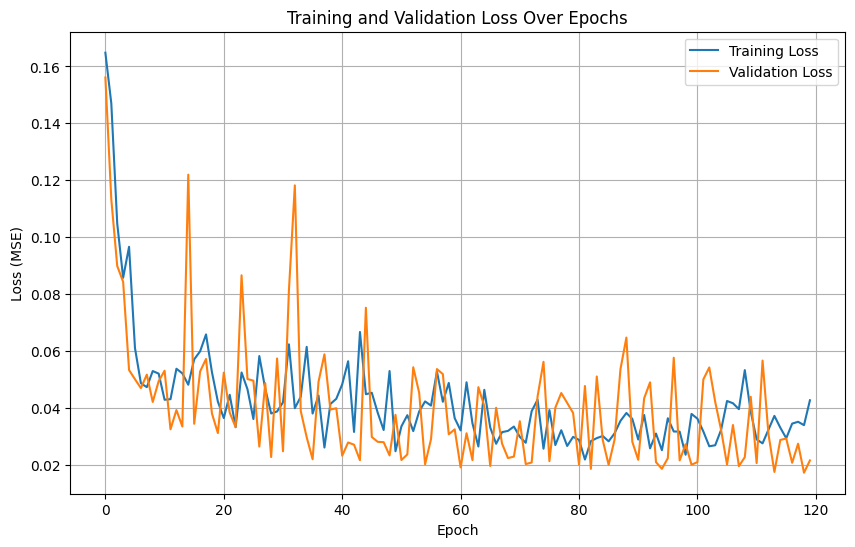


VISUALISASI PERBANDINGAN AUDIO



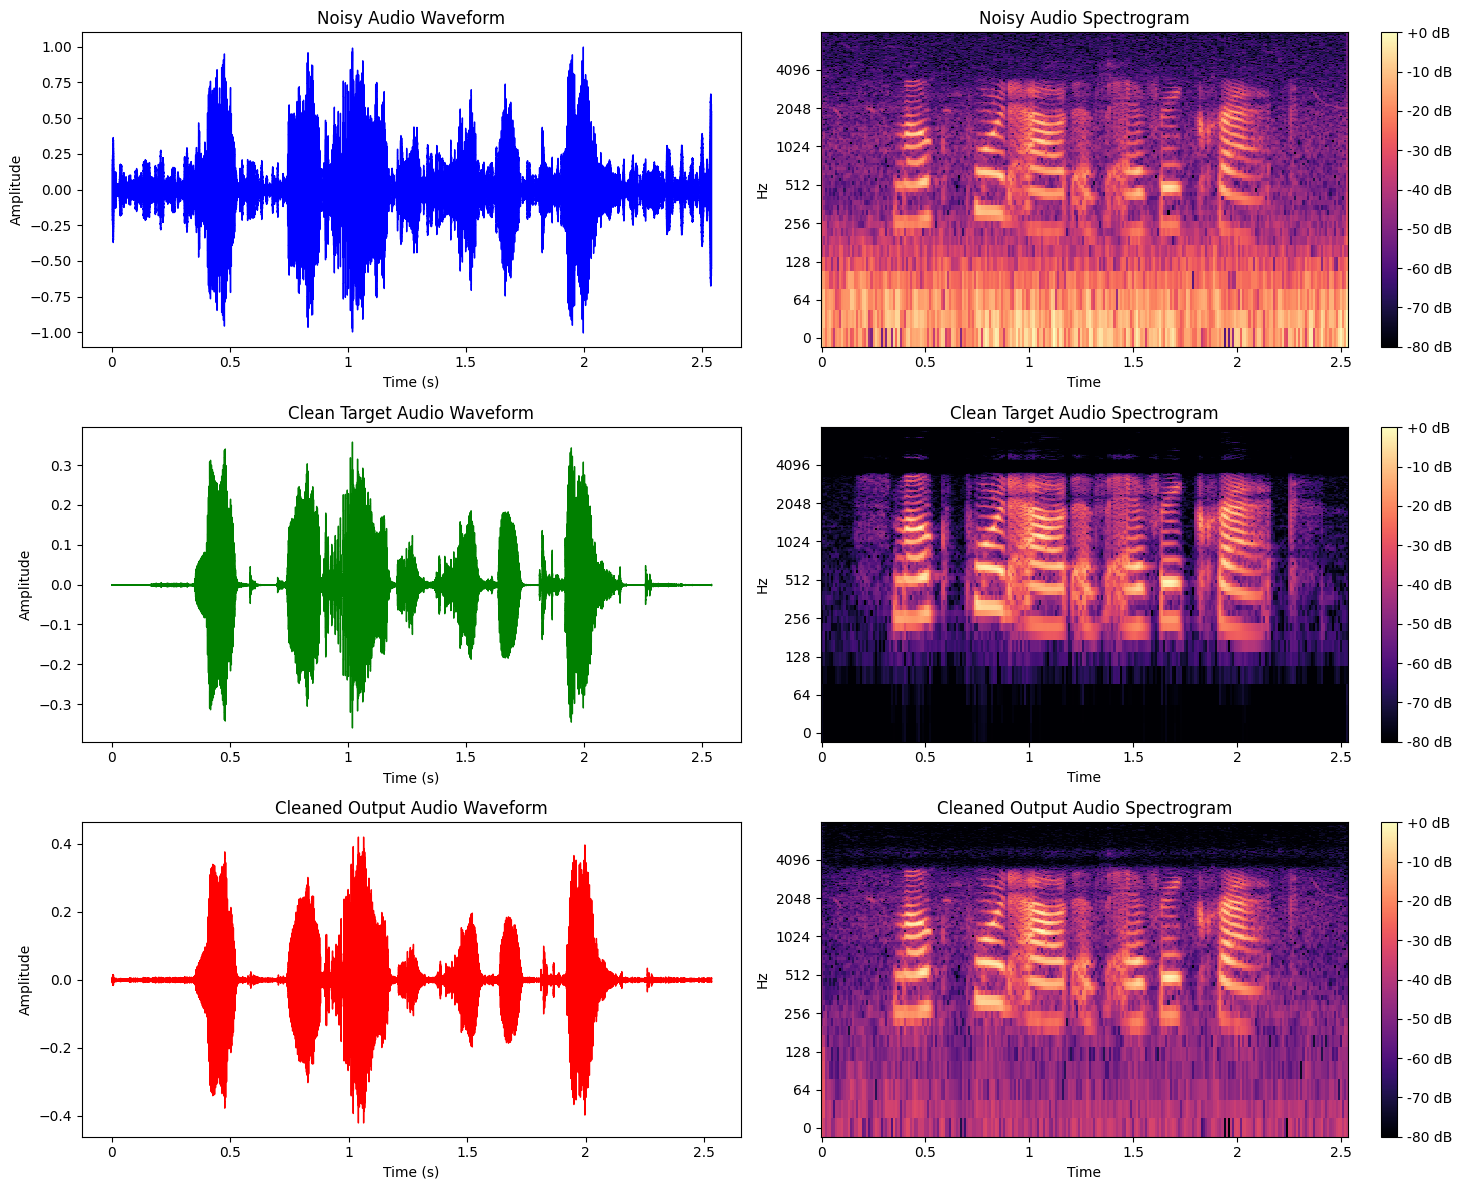


VISUALISASI SELESAI


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

def plot_audio_comparison(noisy_path, clean_path, cleaned_output_path, sr=SAMPLE_RATE):
    noisy_wav, _ = librosa.load(noisy_path, sr=sr)
    clean_wav, _ = librosa.load(clean_path, sr=sr)
    cleaned_wav, _ = librosa.load(cleaned_output_path, sr=sr)

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # Plot Waveforms
    axes[0, 0].set_title('Noisy Audio Waveform')
    librosa.display.waveshow(noisy_wav, sr=sr, ax=axes[0, 0], color='blue')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')

    axes[1, 0].set_title('Clean Target Audio Waveform')
    librosa.display.waveshow(clean_wav, sr=sr, ax=axes[1, 0], color='green')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Amplitude')

    axes[2, 0].set_title('Cleaned Output Audio Waveform')
    librosa.display.waveshow(cleaned_wav, sr=sr, ax=axes[2, 0], color='red')
    axes[2, 0].set_xlabel('Time (s)')
    axes[2, 0].set_ylabel('Amplitude')

    # Plot Spectrograms
    D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_wav, n_fft=N_FFT, hop_length=HOP_LENGTH)), ref=np.max)
    img_noisy = librosa.display.specshow(D_noisy, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[0, 1])
    axes[0, 1].set_title('Noisy Audio Spectrogram')
    fig.colorbar(img_noisy, ax=axes[0, 1], format="%+2.0f dB")

    D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_wav, n_fft=N_FFT, hop_length=HOP_LENGTH)), ref=np.max)
    img_clean = librosa.display.specshow(D_clean, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[1, 1])
    axes[1, 1].set_title('Clean Target Audio Spectrogram')
    fig.colorbar(img_clean, ax=axes[1, 1], format="%+2.0f dB")

    D_cleaned = librosa.amplitude_to_db(np.abs(librosa.stft(cleaned_wav, n_fft=N_FFT, hop_length=HOP_LENGTH)), ref=np.max)
    img_cleaned = librosa.display.specshow(D_cleaned, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[2, 1])
    axes[2, 1].set_title('Cleaned Output Audio Spectrogram')
    fig.colorbar(img_cleaned, ax=axes[2, 1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALISASI PERBANDINGAN AUDIO")
print("="*60 + "\n")

plot_audio_comparison(
    noisy_path="noisy_input_demo.wav",
    clean_path="clean_target_demo.wav",
    cleaned_output_path="cleaned_output_demo.wav",
    sr=SAMPLE_RATE
)

print("\n" + "="*60)
print("VISUALISASI SELESAI")
print("="*60)